# One-Class Classification
**Aprendizaje Automático Avanzado (AAA)**

_Alan García Justel_

El objetivo principal de este _notebook_ es el de explorar diferentes técnicas para detectar "anomalías" en un conjunto de datos o datos nuevos que no se han visto previamente.

**¿Por qué no utilizar un Análisis de Coordenadas Principales?**

El Análisis de Componentes Principales (PCA, por sus siglas en inglés) es una técnica de reducción de dimensionalidad que se utiliza para transformar datos de alta dimensión en un espacio de menor dimensión, manteniendo la mayor cantidad posible de la variación original. Funciona identificando los componentes principales de los datos, que son las direcciones en las que los datos varían más. Estos componentes principales son ortogonales entre sí, y el primer componente principal captura la mayor variación en los datos. El PCA también puede usarse para la detección de anomalías. Las anomalías en datos de alta dimensión pueden ser difíciles de detectar debido a la "maldición de la dimensionalidad". El PCA puede reducir la dimensionalidad de los datos mientras conserva la mayor parte de la variación original.

Sin embargo, es importante tener en cuenta que el PCA asume que los datos tienen relaciones lineales y que los componentes principales representan características significativas. Puede no ser efectivo para datos altamente no lineales o con relaciones complejas entre las características. Además, el PCA puede no ser eficaz para identificar anomalías raras si el patrón normal domina los datos.

Es por ello que se van a realizar una serie de experimentos sobre el [_Wine Dataset_](https://archive.ics.uci.edu/dataset/109/wine), un conjunto de datos que identifica 13 atributos para 177 tipos de vino distintos y los clasifica en 3 clases diferentes (71 de tipo 1, 58 de tipo 2 y 48 de tipo 3). Sin embargo, las anotaciones de los vinos no se van a emplear más que para labores de visualización.

> **Los labels solo se utilizan para visualizar. Estamos con One Class Classification!!!**

## Setup

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

import torch

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Análisis del Dataset

In [5]:
### FUNCIONES DE AYUDA #####################################################################
def load_wine_dataset(wine_path: str, 
                      class_of_interest: int = None, 
                      normalize = True) -> tuple:
    attributes_names = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash  ", 
                        "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols", 
                        "Proanthocyanins", "Color intensity", "Hue", 
                        "OD280/OD315 of diluted wines", "Proline"]

    wine_dataframe = pd.read_csv(wine_path, header = None)
    if class_of_interest is not None:
        # Filter by the class name
        wine_dataframe = wine_dataframe[wine_dataframe.iloc[:, 0] == class_of_interest]

    Y = wine_dataframe.iloc[:, 0] # The first column is the wine class
    X = wine_dataframe.iloc[:, 1:] # The other columns are the data

    if normalize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = pd.DataFrame(X_scaled)
    
    # Set up the attribute names
    X.columns = attributes_names
    Y.columns = ['Labels']
    return X, Y

# Label colormap
label2color = {
    1: (162, 78, 255),
    2: (0, 235, 111),
    3: (0, 122, 210)
}
label2color = {key: tuple(value / 255 for value in rgb) for key, rgb in label2color.items()}

# Extraer los datos de una única clase
def extract_one_class(X: pd.DataFrame, Y: pd.DataFrame, label: int) -> tuple:
    mask = Y == label
    return X[mask], Y[mask]


In [6]:
# Cargar el Dataset
X, Y = load_wine_dataset("../../data/AAA/wine.data")
df = pd.concat([X, Y], axis=1)
print(Y.value_counts())
X.describe()

0
2    71
1    59
3    48
Name: count, dtype: int64


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


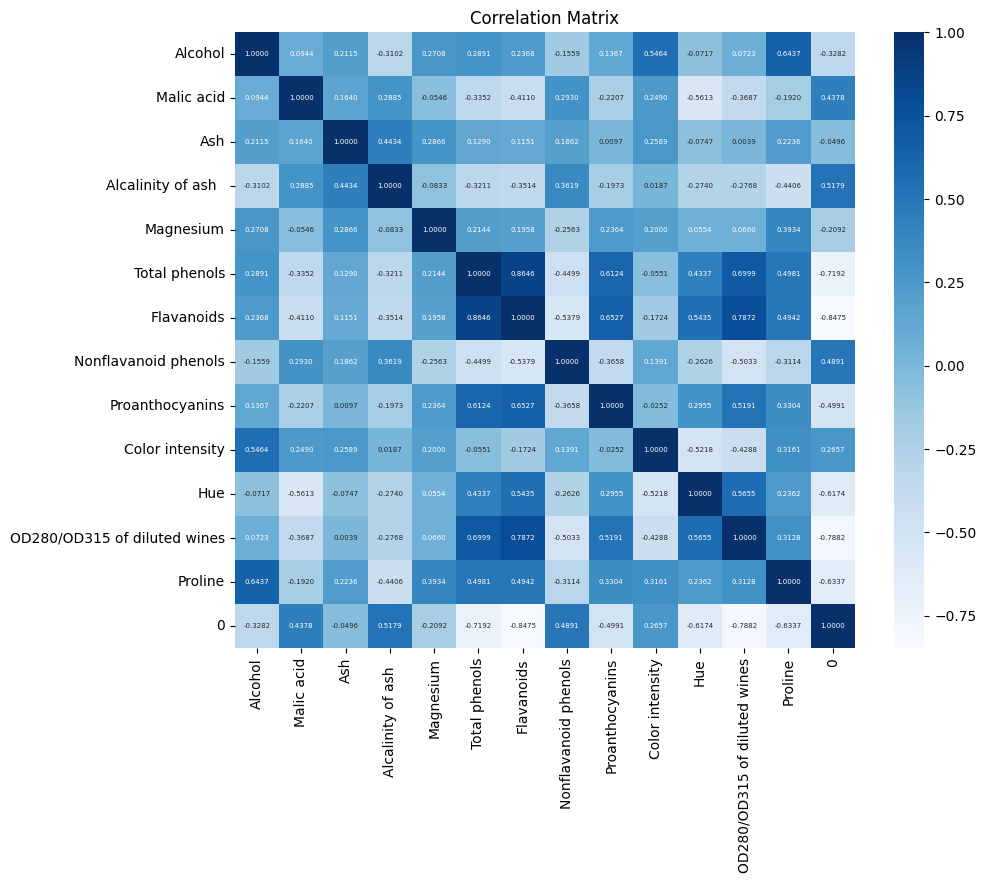

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues', annot_kws={'size': 5})
plt.title('Correlation Matrix')
plt.show()

En este caso particular sí que parece que exista una relación lineal entre las variables y las etiquetas o clasificaciones de los tipos de vino, luego si aplicamos un PCA para visualizar los datos se deberían de agrupar formando clústers de cada clase.

## Local Outlierness Factor (LOF)

El algoritmo Local Outlier Factor (LOF) es un método no supervisado para la detección de anomalías que calcula la desviación de densidad local de un punto de datos dado con respecto a sus vecinos. Considera como anomalías a las muestras que tienen una densidad sustancialmente menor que la de sus vecinos.

In [8]:
### LocalOutlierFactor #####################################################################
clf = LocalOutlierFactor(n_neighbors=20)
outliers_pred = clf.fit_predict(X)
outlierness = pd.DataFrame({"outlierness": clf.negative_outlier_factor_, "outliers_pred": outliers_pred})

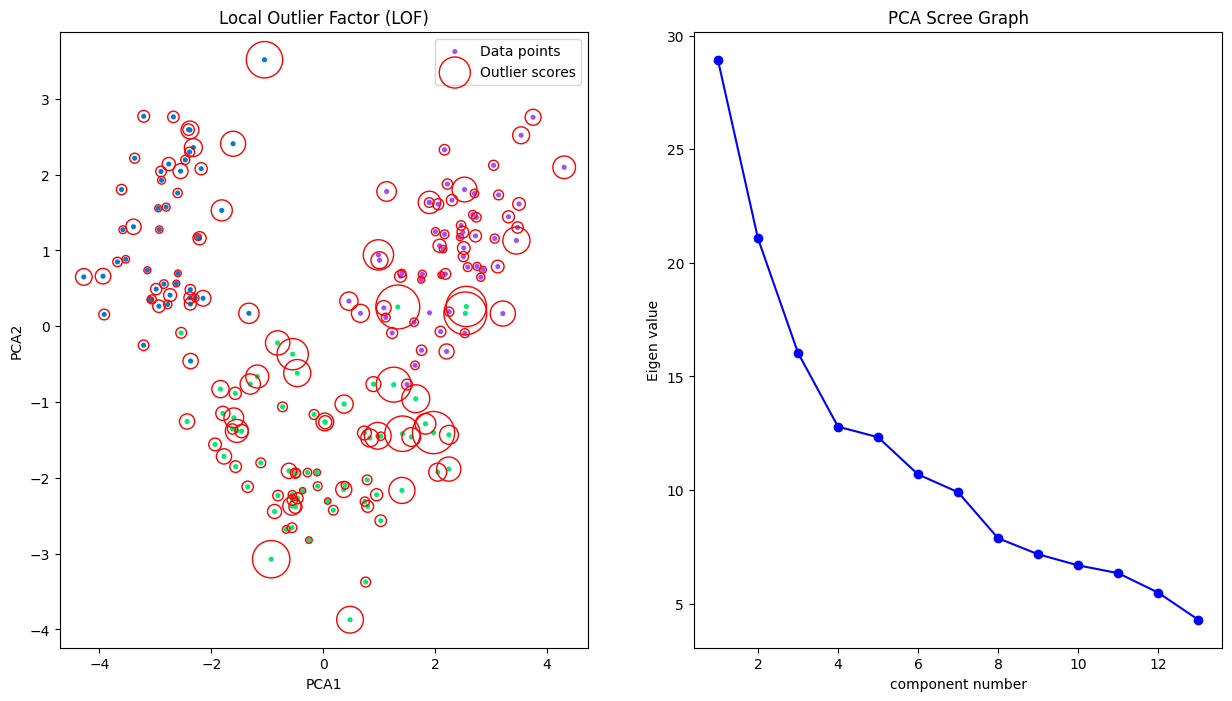

In [10]:
# Representar el outlierness de cada instancia con un scatter
def plot_raius_outlierness(X: pd.DataFrame, Y:pd.DataFrame, outlierness: pd.DataFrame):
    # Los labels reales se utiilzan únicamente para visualizar
    # En un entorno real no se contaría con Y

    # Para calcular el scree graph
    all_pca = PCA(n_components=len(X.columns))
    all_pca.fit(X)
    # print(f"PLOTTING OUTLIERNESS\nPCA variabilidad: {all_pca.explained_variance_ratio_}\nAutovalores: {all_pca.singular_values_}")
    
    # Reducir a las 2 dimensiones más representativas con PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    radius = (outlierness["outlierness"].max() - outlierness["outlierness"]) / (outlierness["outlierness"].max() - outlierness["outlierness"].min())
    color = Y.map(lambda label: label2color[label])

    # Plotear el scree graph y las instancias-outlierness
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    ax1.set_title('Local Outlier Factor (LOF)')
    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], color=color, s=7.0, label="Data points")
    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], s=1000 * radius, edgecolors="r", facecolors="none", label="Outlier scores")
    ax1.set(xlabel='PCA1', ylabel='PCA2')
    ax1.legend()
    
    ax2.set_title('PCA Scree Graph')
    ax2.plot(range(1,len(all_pca.singular_values_ )+1), all_pca.singular_values_, marker='o', c='blue', label='Variabilidad PCA')
    ax2.set(xlabel='component number', ylabel='Eigen value')
    
    plt.show()

plot_raius_outlierness(X, Y, outlierness)

En este caso, el valor del _outlierness_ calculado con LOF se corresponde en mayor o menor medida al esperado por los agrupamientos de las clases observadas con la reducción PCA. Sin embargo, este es un caso particular en el que existe una correlación relativamente elevada entre los atributos y las clases.

## Autoencoders

La idea es entrenar un autoencoder con los datos de la clase 2 del Wine Dataset pero extrayendo todos los outliers y 10 instancias normales del dataset. Luego, una vez entrenado, probar si el autoencoder reconstruye bien o no los outliers extraidos y las instancias de otras clases. El objetivo es que el autoencoder aprenda la "Normalidad" de la clase 2 y ver si reacciona ante outliers o instancias de otras clases. Además, también es interesante comprobar si las instancias que no se reconstruyen bien (tienen mayor error) se corresponden con los outliers identificados con LOF.

### Generar los conjuntos de entrenamiento y test

Para generar los conjuntos de entrenamiento se va a seguir este procedimiento: 
1. Tomar todas las instancias de la clase 2 quitando los outliers
2. Realizar un split `X_train` y `X_test` 
3. Realizar el test con todos los datos

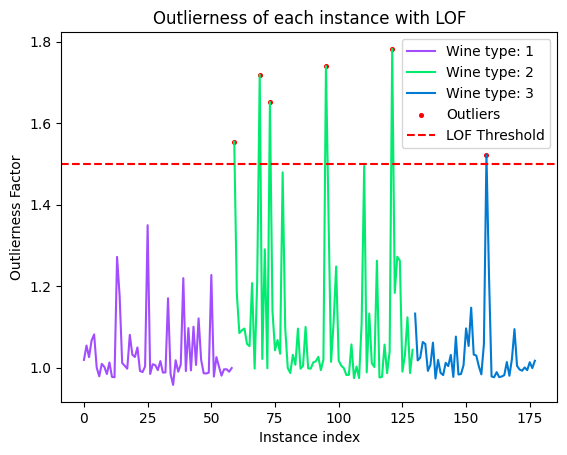

In [157]:
# Representar el outlierness de cada instancia 
def plot_instance_outlierness(Y: pd.DataFrame, outlierness: pd.DataFrame, threshold=1.5, show = True):
    labels = np.unique(Y)
    for l in labels:
        mask = Y == l
        plt.plot(-outlierness["outlierness"][mask], c = label2color[l], label=f"Wine type: {l}")
        plt.plot()

    # Dibujar puntos en los outliers determinados por LOF
    mask = outlierness["outliers_pred"] == -1
    x_ = outlierness.index[mask]
    y_ = -outlierness["outlierness"][mask]
    plt.scatter(x_, y_, color="red", s=7.0, label = "Outliers")

    # Dibujar el threshold que el algoritmo ha aplicado
    # para determinar si se trata de un outlier o no
    #
    # De la documentación:
    # offset_:
    #   Offset used to obtain binary labels from the raw scores. Observations having a negative_outlier_factor 
    #   smaller than offset_ are detected as abnormal. The offset is set to -1.5 (inliers score around -1), except 
    #   when a contamination parameter different than “auto” is provided. In that case, the offset is defined in 
    #   such a way we obtain the expected number of outliers in training.
    plt.axhline(y=-threshold, color='r', linestyle='--', label="LOF Threshold")


    plt.title("Outlierness of each instance with LOF")
    plt.xlabel("Instance index")
    plt.ylabel("Outlierness Factor") 
    if show:
        plt.legend()
        plt.show()
    
plot_instance_outlierness(Y, outlierness, threshold=clf.offset_)

In [132]:
# Tomamos el conjunto de la clase 2 sin outliers
not_out = outlierness["outliers_pred"] == 1
X_class2, _ = extract_one_class(X[not_out], Y[not_out], label=2)
X_train, X_test_class2 = train_test_split(X_class2, train_size=0.9)

# Mostrar X_train
print(f"Longitud del train: {len(X_train)}\nLongitud del test: {len(X_test_class2)}")
X_train.head()

Longitud del train: 59
Longitud del test: 7


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
100,-1.137207,-0.230114,-2.436346,-0.599052,-0.192495,-0.104332,0.141289,-0.820719,-0.334471,-0.760497,1.371265,0.491974,-0.117486
74,-1.285439,-1.118801,-0.243142,0.451946,0.088358,1.738350,0.111170,-1.868234,0.103550,-0.799428,0.142810,0.732090,0.442985
109,-1.717782,-0.885409,1.218995,0.151661,-0.403135,0.712858,0.894264,-0.578985,1.575301,-1.041667,0.011190,0.915707,-0.213021
102,-0.816038,0.102021,0.341713,0.451946,-0.122282,0.424438,0.081051,-0.176095,-0.492158,-0.976782,-0.690784,1.085200,-0.983669
106,-0.927212,-0.544297,-0.901103,-0.148624,-1.386122,-1.033684,0.000733,0.065639,0.068508,-0.717240,0.186684,0.788587,-0.754385


En general tenemos muy pocos datos para realizar un entrenamiento de una red profunda, por lo que se va a tratar de simplificar el autoencoder lo máximo posible.

### Entrenar el Autoencoder

In [133]:
# Autoencoder Module
# 13 ==> 4 ==> 13
class AE(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # num_features ==> 4
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_features, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 4)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 4 ==> num_features
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, num_features)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [192]:
model = AE(len(X.columns))  # Model Initialization
loss_function = torch.nn.MSELoss() # MSE Loss function

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 1e-8)

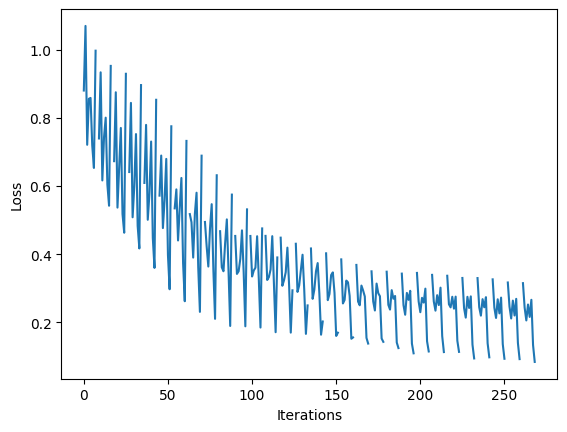

In [193]:
epochs = 30
batch_dim = 8
train_length = len(X_class2)
losses = []
X_train_torch = torch.tensor(X_train.to_numpy(), dtype=torch.float)
# Train loop
for epoch in range(epochs):
  batches = list(gen_batches(train_length, batch_dim))
  for batch in batches:
    batch = X_train_torch[batch.start:batch.stop] 

    # Output of Autoencoder
    reconstructed = model(batch)
       
    # Calculating the loss function
    loss = loss_function(reconstructed, batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
       
    # Guardar el loos
    losses.append(loss.item())
 
# Defining the Plot Style
plt.style.use('default')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses)

> Esta gráfica de loss es muy muy rara. No se qué está pasando

Ahora se calcula el error sobre el conjunto de test sin outliers del mismo tipo de vino y se define el threshold para identificar outliers como el máximo loss sobre este conjunto.

In [196]:
def max_loss_with_set(dataset:torch.tensor, verbose = False):
    max_loss = 0.0
    for item in dataset:
        reconstructed = model(item)
        loss = loss_function(reconstructed, item).item()
        max_loss = max(loss, max_loss)
        if verbose:
            print(f"Original: {item}")
            print(f"Reconstructed: {reconstructed}")
            print(f"loss: {loss}")
            print()
        return max_loss
X_test_class2_torch = torch.tensor(X_test_class2.to_numpy(), dtype=torch.float)

outlier_threshold = max_loss_with_set(X_test_class2_torch)
#outlier_threshold = max(outlier_threshold, max_loss_with_set(X_train_torch))
outlier_threshold

0.20565465092658997

Calcular el outlierness sobre todo el conjunto de datos y graficar los resultados

<function matplotlib.pyplot.show(close=None, block=None)>

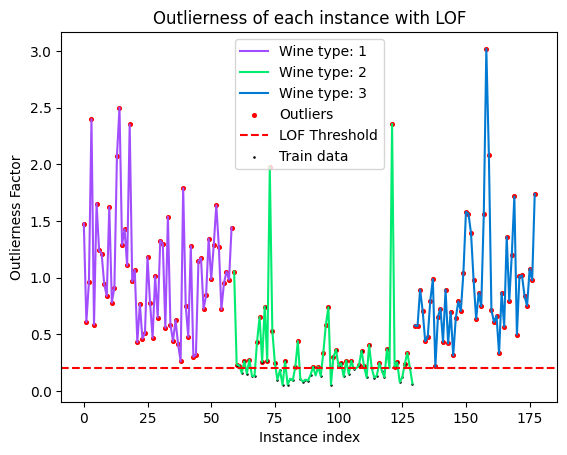

In [197]:
outlierness_ae = []
for item in torch.tensor(X.to_numpy(), dtype=torch.float):
    reconstructed = model(item)
    loss = loss_function(reconstructed, item).item()
    is_outlier = 1 # 1 is not, -1 it is
    if loss > outlier_threshold:
        is_outlier = -1
    outlierness_ae.append({"outlierness": -loss, "outliers_pred": is_outlier})

indices = X.index[X.isin(X_train.to_dict(orient='list')).all(axis=1)].tolist()
outlierness_ae = pd.DataFrame(outlierness_ae)
plot_instance_outlierness(Y, outlierness_ae, threshold=-outlier_threshold, show=False)
plt.scatter(indices, -outlierness_ae.iloc[indices]['outlierness'], s=0.7, c="black", label="Train data")
plt.legend()
plt.show

> Salen outliers hasta en el propio conjunto de entrenamiento. Hay algo que no se está haciendo bien

El resultado esperado es que el autoencoder es capaz de aprender la _normalidad_ y, por lo tanto, los datos de train y test no deberían de superar el _outlier threshold_ pero los outliers de la clase 2 y las instancias de las otras 2 clases sí que deberían mostrarse como outliers. Sería interesante ver cómo se comporta el autoencoder en el caso del outlier de la clase 3 dado por _LOF_ ya que quizá lo interprete como _normal_ para los datos de la clase 2.  